In [1]:
import os
 
def set_dir(path):
    os.chdir(path)
    print(f"Working directory is now: {os.getcwd()}")
    
print(f"Working directory is now: {os.getcwd()}")
current_dir = os.path.dirname('/home/lunxu/yangqh/FEN/Linear/Helmholtz2D/cosELM/')
set_dir(current_dir)

Working directory is now: /home/lunxu/yangqh/FEN/Linear/Helmholtz2D/cosELM
Working directory is now: /home/lunxu/yangqh/FEN/Linear/Helmholtz2D/cosELM


In [2]:
import logging
import sys
from pyDOE import lhs
import torch
import torch.nn as nn   
from init_config import *
from train_config import *
from model import INIT_TYPE, MODEL_NAME

# 打印相关信息
def log(obj):
    print(obj)
    logging.info(obj)

In [3]:
# cuda 调用
device = 'cuda'
# 设置需要写日志
init_log()

param_dict = {
    'lb': lb,
    'ub': ub,
    'device': device,
    'path': path,
    'root_path': root_path,
}

### 生成训练点 ####

TRAIN_GRID_SIZE = 100
X = np.linspace(lb[0], ub[0], TRAIN_GRID_SIZE+1)
Y = np.linspace(lb[1], ub[1], TRAIN_GRID_SIZE+1)

xb0 = np.reshape(X, (X.shape[0], 1))
yb1 = 0*xb0 + lb[1]
yb2 = 0*xb0 + ub[1]
xb = np.concatenate((xb0, xb0), axis=0)
yb = np.concatenate((yb1, yb2), axis=0)

yb0 = np.reshape(Y, (Y.shape[0], 1))
xb1 = 0*yb0 + lb[0]
xb2 = 0*yb0 + ub[0]
xb = np.concatenate((xb, xb1, xb2), axis=0)
yb = np.concatenate((yb, yb0, yb0), axis=0)

X = X[1:-1]
Y = Y[1:-1]
X = np.asarray(X, dtype=float)
Y = np.asarray(Y, dtype=float)
X_TRAIN, Y_TRAIN = np.meshgrid(X, Y)

X_Train = np.hstack((X_TRAIN.flatten()[:, None], Y_TRAIN.flatten()[:, None]))

# N_R = 2500
# X_Train = lb + (ub-lb)*lhs(2, N_R)

x = X_Train[:, 0:1]
y = X_Train[:, 1:2]
    
VALID_GRID_SIZE = 200
X = np.linspace(lb[0], ub[0], VALID_GRID_SIZE+1)
Y = np.linspace(lb[1], ub[1], VALID_GRID_SIZE+1)
X = np.asarray(X, dtype=float)
Y = np.asarray(Y, dtype=float)
X_VALID, Y_VALID = np.meshgrid(X, Y)

X_Valid = np.hstack((X_VALID.flatten()[:, None], Y_VALID.flatten()[:, None]))
x_valid = X_Valid[:, 0:1]
y_valid = X_Valid[:, 1:2]


N_basis = 2500
in_num = 2
out_num = N_basis
layer_num = N_basis

# 打印参数
log_str = 'TRAIN_GRID_SIZE '+str(TRAIN_GRID_SIZE) + ' VALID_GRID_SIZE '+str(VALID_GRID_SIZE) + ' N_basis ' + str(N_basis)
log(log_str)

# 训练参数
train_dict = {
    'x': x,
    'y': y,
    'xb': xb,
    'yb': yb,
    'x_valid': x_valid,
    'y_valid': y_valid,
    'a1': a1,
    'a2': a2,
    'k': k,
    'funQ': funQ,
    'funH': funH,
    'funU': funU,
    'N_basis': N_basis,
}

TRAIN_GRID_SIZE 100 VALID_GRID_SIZE 200 N_basis 2500


In [4]:
def train_Adam(model, device, scale, param_dict, train_dict, Adam_steps=50000,  Adam_init_lr=1e-3, scheduler_name=None, scheduler_params=None):
    '''
    用Adam训练
    '''
    # 记录时间
    start_time = time.time()
    model.scale = nn.Parameter(torch.ones((1, 1))*scale)
    model.to(device)
    model_config = PINNConfig(param_dict=param_dict,
                              train_dict=train_dict, model=model)
    # 用Adam训练
    if model_config.params is not None:
        params = model_config.params
    else:
        params = model.parameters()
    model_config.train_Adam(params=params, Adam_steps=Adam_steps, Adam_init_lr=Adam_init_lr,
                            scheduler_name=scheduler_name, scheduler_params=scheduler_params)
    # 打印总耗时
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    logging.info('Training time: %.4f' % (elapsed))

In [5]:
step = 0.1
stop = 1000
Ns = [400, 900, 1600, 2500]
for N_basis in Ns:
    out_num = N_basis
    train_dict['N_basis'] = N_basis
    layers = [in_num, out_num]
    # layers = [in_num, layer_num, layer_num, layer_num, out_num]
    model_name = MODEL_NAME.cosELM
    model_dict = {
        'layers': layers,
        'init_type': INIT_TYPE.Uniform,
        'init_params':{
            'var': 1
        }
    }
    # 获取神经网络模型
    model = get_model(model_dict, model_name)
    log(model_dict)
    for i in range(1, stop+1):
        scale = i * step
        log('N_basis ' +str(N_basis) + ' scale ' + str(scale))
        train_Adam(model, device, scale, param_dict, train_dict, Adam_steps=1)

{'layers': [2, 400], 'init_type': 'uniform', 'init_params': {'var': 1}}
N_basis 400 scale 0.1
Elapsed Time: 0.6519s
u_infty 95.80838114859506 u_rel_l2 40.08204207104533
u_infty 102.0 u_rel_l2 41.2062536673481
loss_infty 236.53724322443892 loss_rel_l2 0.9236623741085507
Time: 0.6761s Per 1 Iterators
Training time: 1.0741
N_basis 400 scale 0.2
Elapsed Time: 0.0144s
u_infty 99.54182502899643 u_rel_l2 50.624272202380745
u_infty 102.43590375695213 u_rel_l2 51.62199992475933
loss_infty 258.9272209921081 loss_rel_l2 0.9244723917062013
Time: 0.0161s Per 1 Iterators
Training time: 0.0702
N_basis 400 scale 0.30000000000000004
Elapsed Time: 0.0145s
u_infty 105.81593772365765 u_rel_l2 62.39215092411465
u_infty 113.96109633054046 u_rel_l2 63.603800806729076
loss_infty 511.10438208190624 loss_rel_l2 0.8712225831896586
Time: 0.0162s Per 1 Iterators
Training time: 0.1024
N_basis 400 scale 0.4
Elapsed Time: 0.0143s
u_infty 191.29002418347676 u_rel_l2 100.4668973952279
u_infty 193.65608869936074 u_rel_l

In [6]:
# 日志读取
u_inftys = []
u_rel_l2s = []
loss_inftys = []
loss_rel_l2s = []

PINN_log_path = root_path + '/' + path + '/log.txt'

# step值越过多少个点再记录
def read_PINN_log(PINN_log_path, step=1):
    with open(PINN_log_path, 'r') as fs:
        line_num = 0
        while True:
            line = fs.readline()  # 整行读取数据
            if not line:
                break
            datas = line.replace('\n', '').split('INFO:root:')[-1].split(' ')
            if datas is not None:
                if datas[0] == 'u_infty':
                    u_inftys.append(float(datas[1]))
                if datas[2] == 'u_rel_l2':
                    u_rel_l2s.append(float(datas[3]))
                if datas[0] == 'loss_infty':
                    loss_inftys.append(float(datas[1]))
                if datas[2] == 'loss_rel_l2':
                    loss_rel_l2s.append(float(datas[3]))

read_PINN_log(PINN_log_path)

u_inftys = u_inftys[::2]
u_rel_l2s = u_rel_l2s[::2]

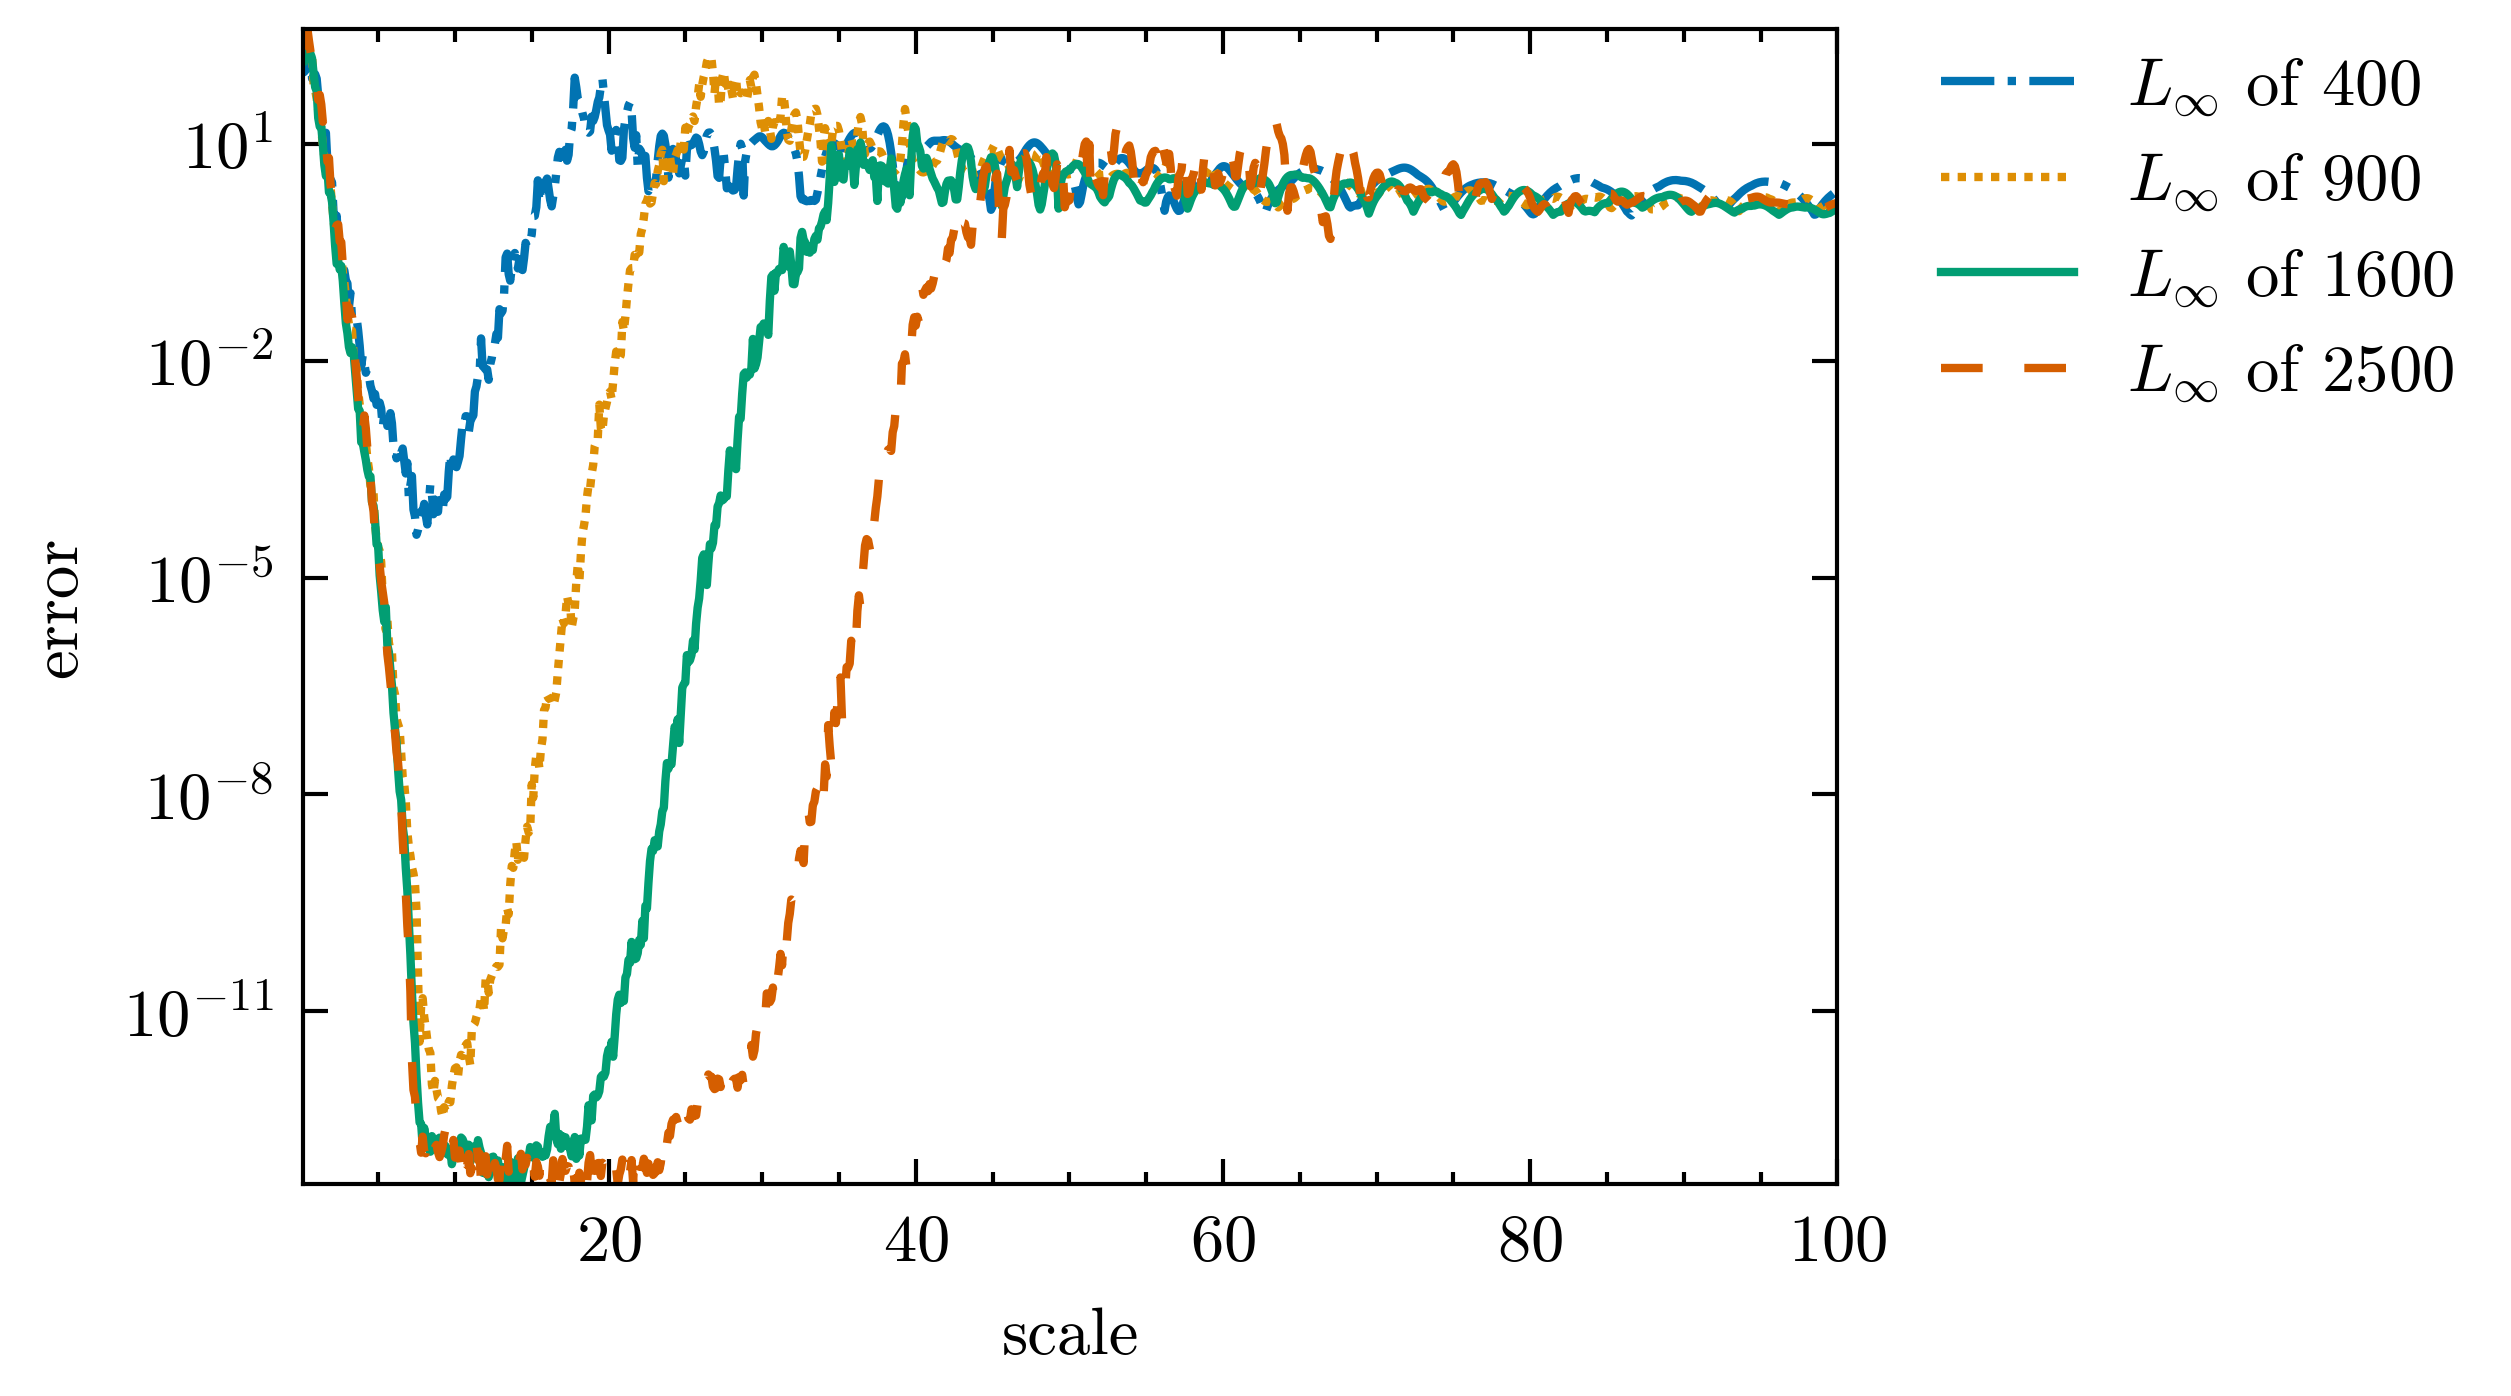

In [7]:
import matplotlib.pyplot as plt
scales = np.asarray([i for i in range(1, stop+1)])*step

top_steps = stop

u_inftys_400 = u_inftys[:top_steps]
u_inftys_900 = u_inftys[top_steps:2*top_steps]
u_inftys_1600 = u_inftys[2*top_steps:3*top_steps]
u_inftys_2500 = u_inftys[3*top_steps:4*top_steps]

loss_inftys_400 = loss_inftys[:top_steps]
loss_inftys_900 = loss_inftys[top_steps:2*top_steps]
loss_inftys_1600 = loss_inftys[2*top_steps:3*top_steps]
loss_inftys_2500 = loss_inftys[3*top_steps:4*top_steps]

datas = []
data = np.stack((scales, u_inftys_400), 1)
datas.append(data)
data = np.stack((scales, u_inftys_900), 1)
datas.append(data)
data = np.stack((scales, u_inftys_1600), 1)
datas.append(data)
data = np.stack((scales, u_inftys_2500), 1)
datas.append(data)

data_labels =[]
data_labels.append('$L_{\infty}$ of 400')
data_labels.append('$L_{\infty}$ of 900')
data_labels.append('$L_{\infty}$ of 1600')
data_labels.append('$L_{\infty}$ of 2500')

file_name = root_path + '/' + path + '/u_infty_scale'
xy_labels = [r'$ho$', 'error']
from plot.line import plot_line
plot_line(datas,
              data_labels,
              xy_labels,
              title = None,
              file_name=file_name,
              xlog=False,
              ylog=True)
plt.show()

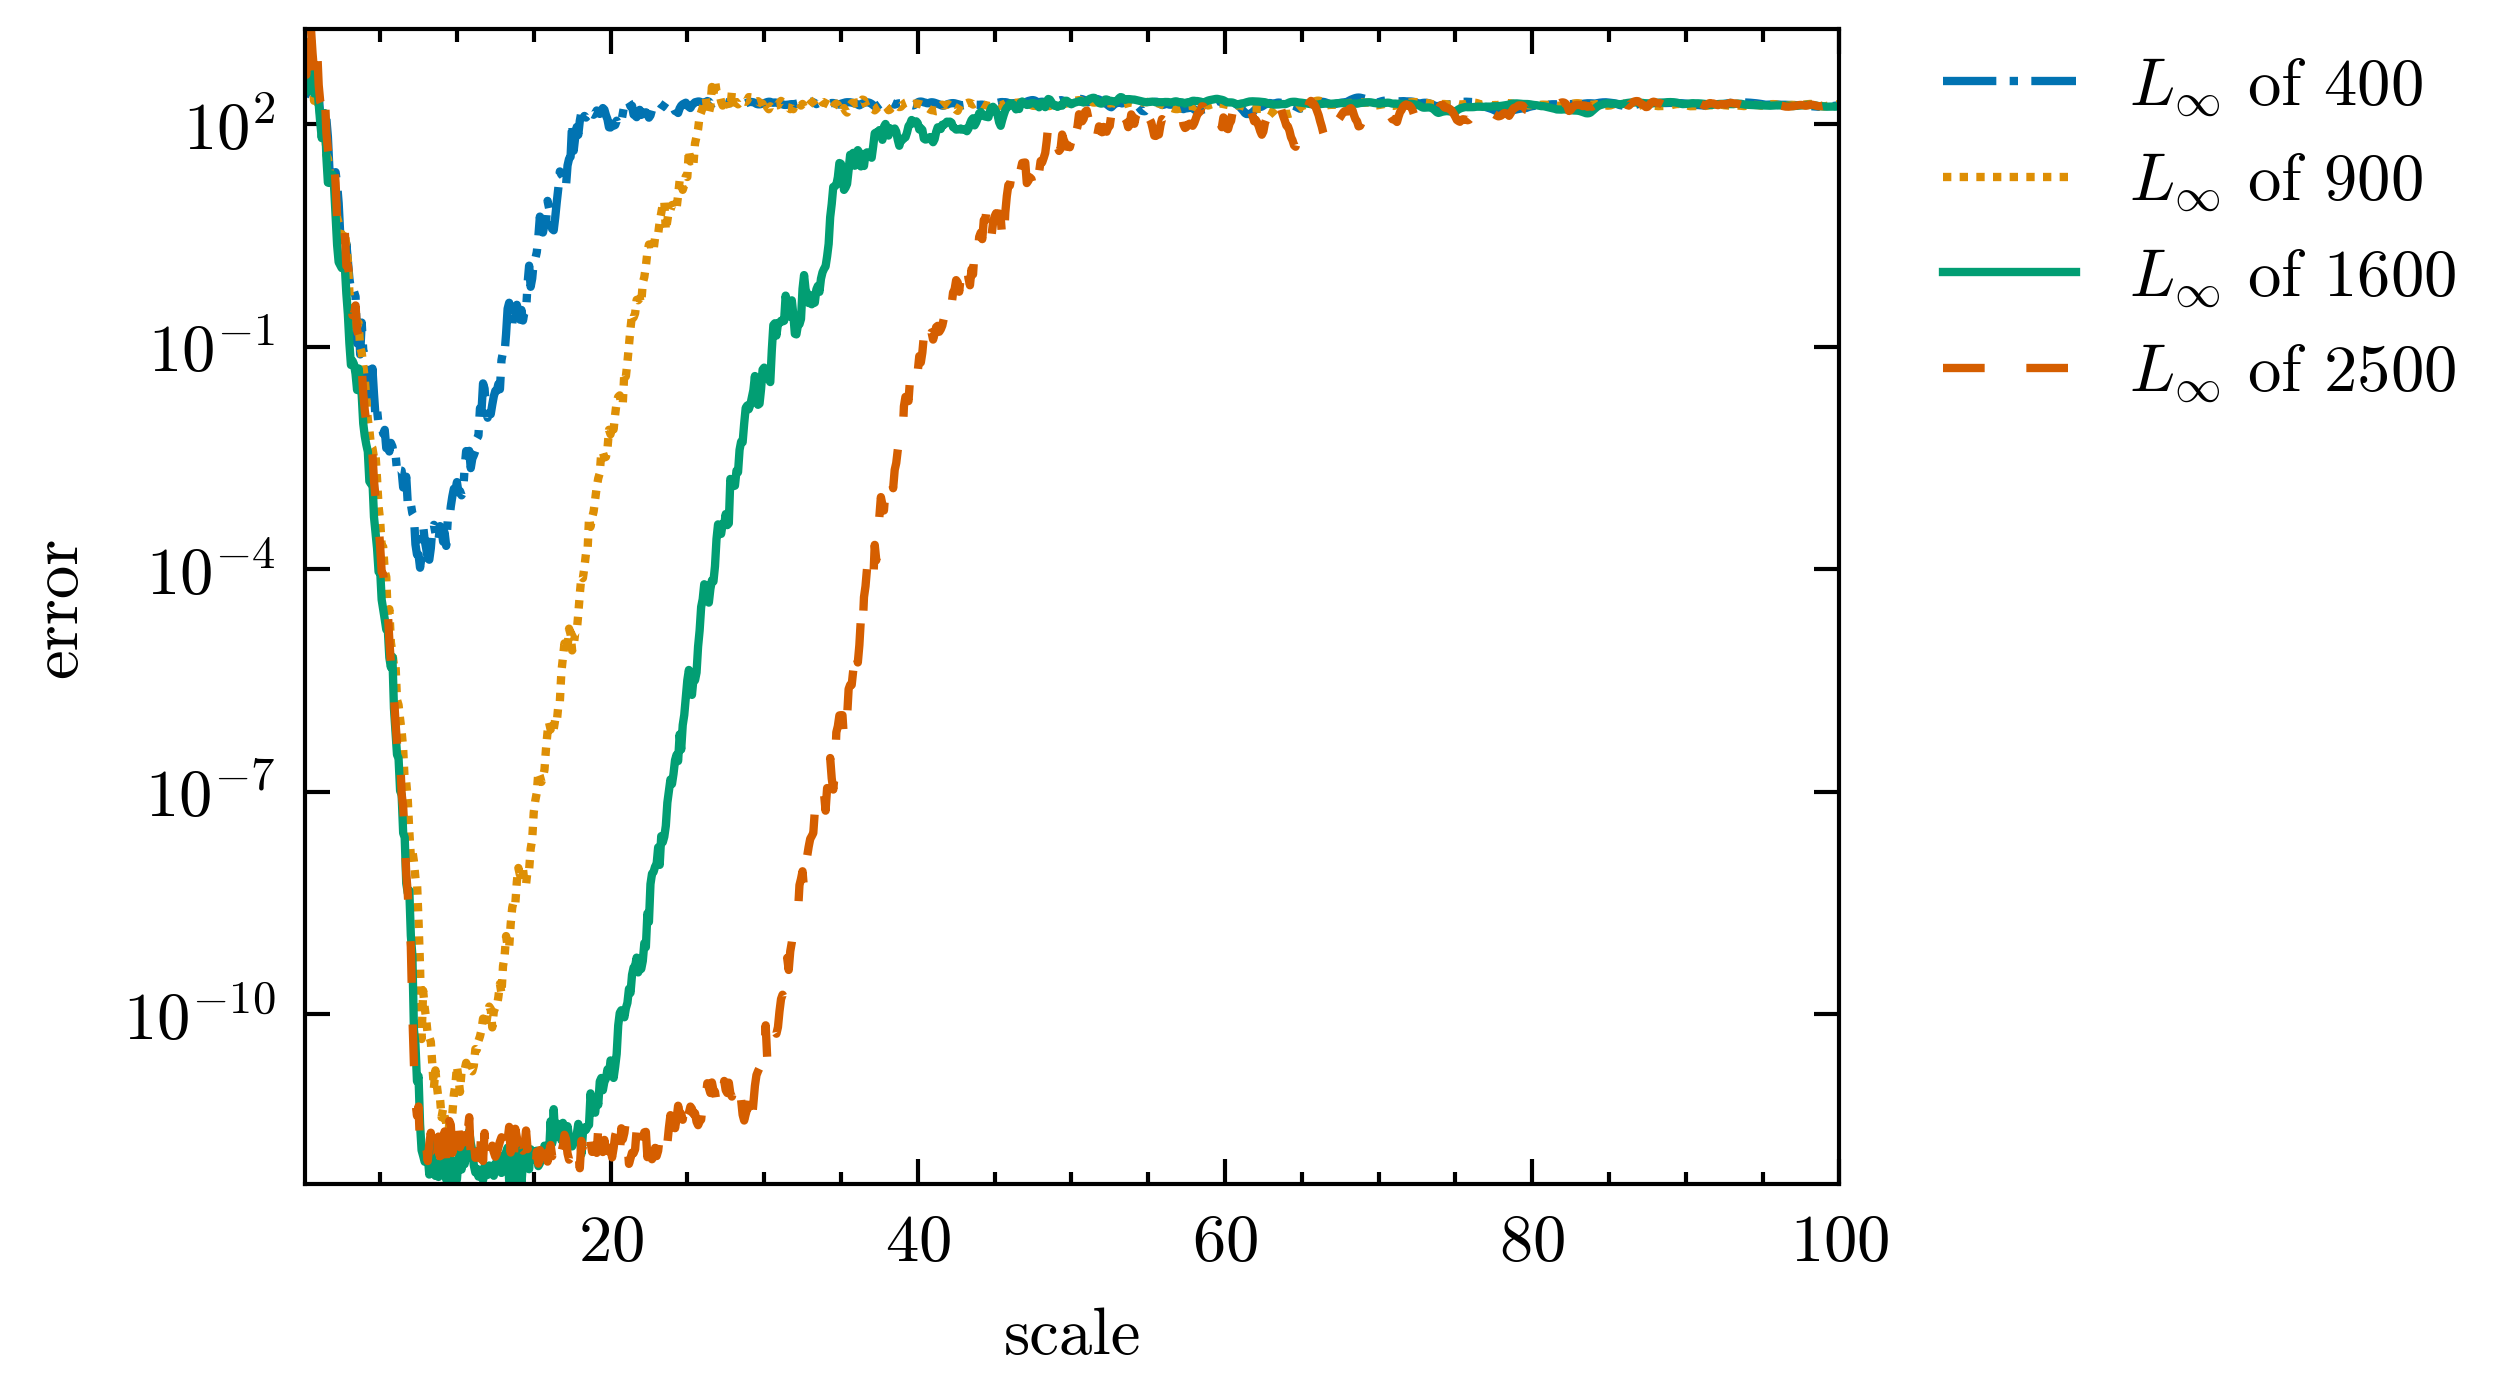

In [8]:
import matplotlib.pyplot as plt
scales = np.asarray([i for i in range(1, stop+1)])*step

top_steps = stop

u_inftys_400 = u_inftys[:top_steps]
u_inftys_900 = u_inftys[top_steps:2*top_steps]
u_inftys_1600 = u_inftys[2*top_steps:3*top_steps]
u_inftys_2500 = u_inftys[3*top_steps:4*top_steps]

loss_inftys_400 = loss_inftys[:top_steps]
loss_inftys_900 = loss_inftys[top_steps:2*top_steps]
loss_inftys_1600 = loss_inftys[2*top_steps:3*top_steps]
loss_inftys_2500 = loss_inftys[3*top_steps:4*top_steps]

datas = []
data = np.stack((scales, loss_inftys_400), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_900), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_1600), 1)
datas.append(data)
data = np.stack((scales, loss_inftys_2500), 1)
datas.append(data)

data_labels =[]
data_labels.append('$L_{\infty}$ of 400')
data_labels.append('$L_{\infty}$ of 900')
data_labels.append('$L_{\infty}$ of 1600')
data_labels.append('$L_{\infty}$ of 2500')

file_name = root_path + '/' + path + '/loss_infty_scale'
xy_labels = [r'$ho$', 'error']
from plot.line import plot_line
plot_line(datas,
              data_labels,
              xy_labels,
              title = None,
              file_name=file_name,
              xlog=False,
              ylog=True)
plt.show()

In [9]:
idx = np.argmin(u_inftys_400)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_900)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_1600)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(u_inftys_2500)
min_scale = scales[idx]
print(min_scale)

7.5
9.200000000000001
13.5
20.6


In [10]:
idx = np.argmin(loss_inftys_400)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_900)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_1600)
min_scale = scales[idx]
print(min_scale)

idx = np.argmin(loss_inftys_2500)
min_scale = scales[idx]
print(min_scale)

7.6000000000000005
9.4
14.200000000000001
15.100000000000001


: 